In [53]:
import pandas as pd
import os,sys,re
import numpy as np

In [54]:
df = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

In [55]:
df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '2/24/21', '2/25/21', '2/26/21', '2/27/21', '2/28/21', '3/1/21',
       '3/2/21', '3/3/21', '3/4/21', '3/5/21'],
      dtype='object', length=413)

In [56]:
israel_death = df[df['Country/Region'] == "Israel"][df.columns[30:]].iloc[0]

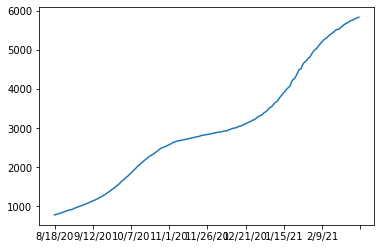

In [57]:
israel_death[-200:].plot()

In [58]:
israel_death.iloc[-1] - israel_death.iloc[-30], israel_death.iloc[-30] - israel_death.iloc[-60] 

(833, 1505)

In [59]:
(1./(1+19.*0.6))*140. * 20. *4

903.2258064516128

In [60]:
israel_death.iloc[-3] - israel_death.iloc[-10]

143

In [61]:
israel_death.index[-3:]

Index(['3/3/21', '3/4/21', '3/5/21'], dtype='object')

In [62]:
(israel_death.iloc[-3] - israel_death.iloc[-10])*0.95 *0.9

122.265

In [63]:
150 *4 

600

In [64]:
beta = 1500 /600.

In [65]:
beta

2.5

In [66]:
(beta -1.)/(beta*0.95)

0.631578947368421

In [67]:
beta2 = 1000/600.

In [68]:
(beta2 -1.)/(beta2*0.95)

0.42105263157894746

In [69]:
(israel_death - israel_death.shift(28)).fillna(0.0).max(),(israel_death - israel_death.shift(28)).fillna(0.0).idxmax()

(1467.0, '2/8/21')

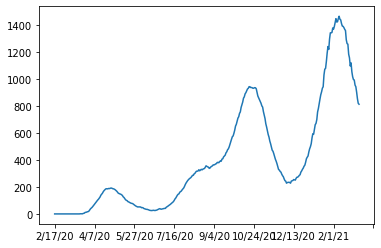

In [70]:
(israel_death - israel_death.shift(28)).fillna(0.0).plot()

In [79]:
import dateutil
from dateutil import parser
tm = parser.parse((israel_death - israel_death.shift(28)).fillna(0.0).idxmax()).strftime("%m/%d%/%Y")

israel_death.loc['2/8/21']

5171

In [81]:
from datetime import timedelta
df = df.rename( columns={c : parser.parse(c) for c in df.columns[30:] })

In [83]:
israel_death = df[df['Country/Region'] == "Israel"][df.columns[30:]].iloc[0]
mx,idx = (israel_death - israel_death.shift(28)).fillna(0.0).max(),(israel_death - israel_death.shift(28)).fillna(0.0).idxmax()

In [90]:
from datetime import datetime
dt64 = idx
ts = (dt64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
ts,datetime.utcfromtimestamp(ts),datetime.utcfromtimestamp(ts)+timedelta(days=10) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  This is separate from the ipykernel package so we can avoid doing imports until


(1612742400.0,
 datetime.datetime(2021, 2, 8, 0, 0),
 datetime.datetime(2021, 2, 18, 0, 0))

In [93]:
ts2 = datetime.utcfromtimestamp(ts)+timedelta(days=10)
mx_dlt10 = (israel_death - israel_death.shift(28)).fillna(0.0).loc[np.datetime64(ts2)]
mx_dlt10/mx

0.8616223585548739

In [160]:
def trans_delta(dt64,delta):
    ts = (dt64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    ts_delta = datetime.utcfromtimestamp(ts)+timedelta(days=delta)
    return np.datetime64(ts_delta)
def ratio_from_max(srs,delta):
    mx,idx = srs.max(),srs.idxmax()
    idx_delta = trans_delta(idx,delta)
    try:
        comp_val = srs.loc[idx_delta]
    except:
        comp_val = 0.0
    return comp_val/mx
def ratio_from_max_double(srs,delta,srs2):
    mx,idx = srs.max(),srs.idxmax()
    idx_delta = trans_delta(idx,delta)
    try:
        comp_val = srs2.loc[idx_delta]
    except:
        comp_val = 0.0
    return comp_val/mx


In [102]:
df['Province/State'] = df['Province/State'].fillna("")
df["State_Country"] = df.apply(lambda r:r['Province/State']+"_"+r['Country/Region'],axis=1)

In [105]:
S = set(df["State_Country"])
Sf = [s for s in S if df[df['State_Country'] == s].iloc[0].iloc[-2]>1000 ]

In [161]:
def mort_x_days(df,state_country,x_days):
    death_sr = df[df['State_Country'] == state_country][df.columns[30:-1]].iloc[0]
    #print(state_country,death_sr[-10:])
    #print( (death_sr - death_sr.shift(x_days)).fillna(0.0)[-10:])
    try:
        X = (death_sr - death_sr.shift(x_days)).fillna(0.0)
    except:
        return False
    return X
mortality_28_days = dict()
for x in Sf:
    m = mort_x_days(df,x,28)
    if not isinstance(m,bool):
        mortality_28_days[x] = m
mortality_7_days = dict()
for x in Sf:
    m = mort_x_days(df,x,7)
    if not isinstance(m,bool):
        mortality_7_days[x] = m

In [162]:
ratio_distr = [(k,ratio_from_max(mortality_28_days[k],20)) for k in mortality_28_days.keys() ]
ratio_distr2 = [(k,ratio_from_max_double(mortality_28_days[k],20,mortality_7_days[k])) for k in mortality_28_days.keys() ]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


In [150]:
max(ratio_distr,key=lambda x: x[1])

('_Belarus', 0.9887640449438202)

In [163]:
ratio_distr.sort(key=lambda x:x[1],reverse=True)
ratio_distr[:10]

[('_Belarus', 0.9887640449438202),
 ('_Russia', 0.9540336468406412),
 ('Hubei_China', 0.9405366207396664),
 ('_Armenia', 0.9008782936010038),
 ('_Romania', 0.894725078229772),
 ('_Bangladesh', 0.8773109243697479),
 ('_Bosnia and Herzegovina', 0.8684573002754821),
 ('_Saudi Arabia', 0.8664546899841018),
 ('_Bolivia', 0.8653500897666068),
 ('_Indonesia', 0.8553669295548724)]

In [165]:
ratio_distr2.sort(key=lambda x:x[1],reverse=True)
ratio_distr2[:150]

[('_Russia', 0.24844350245065572),
 ('_Belarus', 0.23595505617977527),
 ('_Bangladesh', 0.2184873949579832),
 ('_Guatemala', 0.21469465648854963),
 ('_Latvia', 0.20962199312714777),
 ('_Armenia', 0.19698870765370138),
 ('_Indonesia', 0.1959631065365593),
 ('_Burma', 0.19362186788154898),
 ('_Romania', 0.19065713008493518),
 ('_Iraq', 0.18952802359882007),
 ('_Honduras', 0.18733153638814015),
 ('_Costa Rica', 0.1845841784989858),
 ('_Philippines', 0.1780821917808219),
 ('_Argentina', 0.1761346558461076),
 ('_El Salvador', 0.17567567567567569),
 ('_Syria', 0.17314487632508835),
 ('_Lebanon', 0.17231503579952268),
 ('_Hungary', 0.1717014660151044),
 ('_Switzerland', 0.17147192716236723),
 ('_Turkey', 0.17071320182094082),
 ('_Italy', 0.1706801423193936),
 ('_Moldova', 0.17041800643086816),
 ('_India', 0.1702127659574468),
 ('_Libya', 0.16883116883116883),
 ('_Paraguay', 0.16784452296819788),
 ('_Venezuela', 0.16738197424892703),
 ('_Ukraine', 0.16526986255447537),
 ('_Saudi Arabia', 0.164

In [158]:
beta = 0.85 *(1500./974.)
Pv =0.95
beta, (beta-1.)/(beta*Pv)

(1.309034907597536, 0.24850361197110432)

In [157]:
(israel_death - israel_death.shift(7)).fillna(0.0).iloc[-4] *0.95*0.95

140.79

In [167]:
beta = 2.5 #0.17/0.11
Pv =0.95
beta, (beta-1.)/(beta*Pv)

(2.5, 0.631578947368421)